In [217]:
# Alina Artemiuk
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.utils import class_weight
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from keras.models import Model
from keras.layers import Dense, Input
from keras import layers
from keras.callbacks import EarlyStopping
import visualkeras
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import random
import time

In [100]:
warnings.filterwarnings("ignore", category=FutureWarning)

In [101]:
# ensuring reproducibility
seed = 123
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# colormap for plots
cmap = plt.cm.magma(np.linspace(0, 1, 15))

In [102]:
X = np.load("emnist_hex_images.npy")
y = np.load("emnist_hex_labels.npy")

## Exploratory Data Analysis

In [103]:
X.shape, y.shape

((107802, 400), (107802,))

In [104]:
unique_labels, counts = np.unique(y, return_counts=True)

In [105]:
unique_labels, counts

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
       dtype=uint8),
 array([7407, 7642, 7371, 7397, 7397, 7220, 7382, 7451, 7327, 7374, 6022,
        3878, 6198, 4562, 1337, 6159, 5678]))

In [106]:
class_to_label = {
    0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5",
    6: "6", 7: "7", 8: "8", 9: "9", 10: "A", 11: "B",
    12: "C", 13: "D", 14: "E", 15: "F", 16: "None"
}
num_classes = 17

labels = list(class_to_label.values())

### Dataset Overview
Plot with examples of each class to understand the nature of the handwritten images in the dataset.

In [107]:
def plot_examples(X, y):
    """
    Display 5 sample images from each class in the dataset.

    Parameters:
    X (np.array): The image data.
    y (np.array): The labels for each image, corresponding to the class indices.
    """
    fig, axs = plt.subplots(5, num_classes, figsize=(16, 5))

    for j, c in enumerate(unique_labels):
        indices = np.where(y == c)[0][-5:]

        for i, index in enumerate(indices):
            axs[i, j].imshow(X[index].reshape(20, 20), cmap="gray")
            axs[i, j].axis("off")

            if i == 0:
                axs[i, j].set_title(class_to_label[c])

    plt.suptitle("Example Set of Handwritten Hexadecimal Images")

    plt.subplots_adjust(wspace=0.1, hspace=0)
    plt.show()

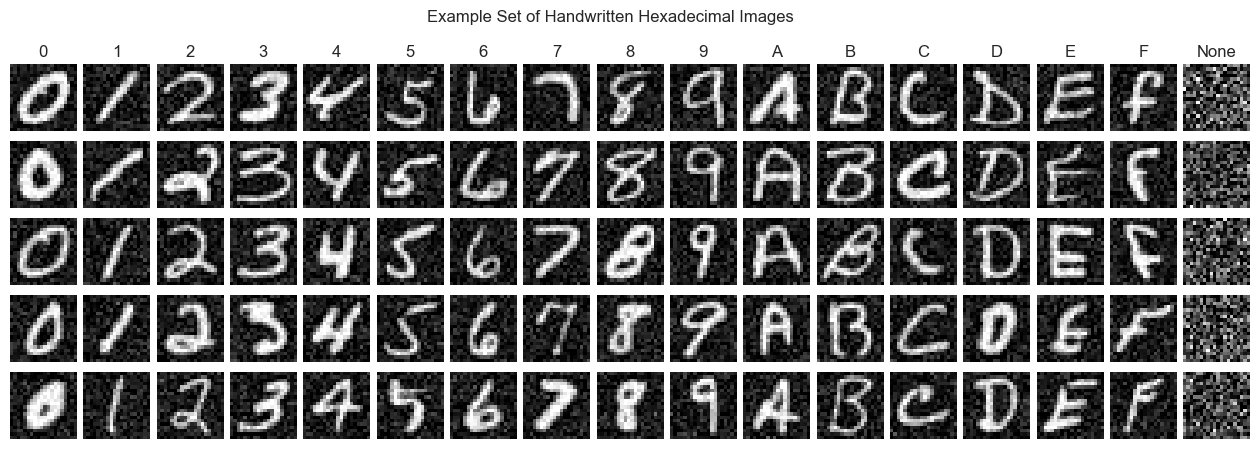

In [108]:
plot_examples(X, y)

### Heatmaps
Patterns reveal and variations in average pixel intensity for each class of handwritten digits.

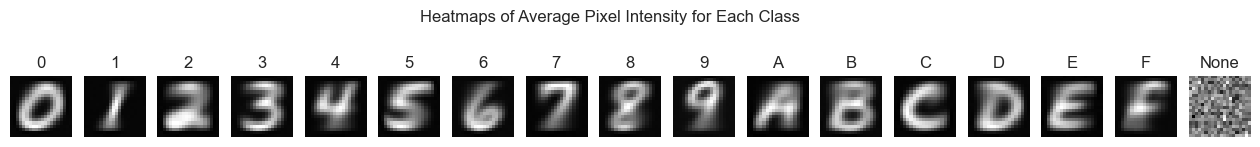

In [109]:
mean_images = {}
for label in unique_labels:
    indices = np.where(y == label)
    mean_images[label] = np.mean(X[indices], axis=0)

fig, axes = plt.subplots(1, num_classes, figsize=(16, 2))

for i, label in enumerate(sorted(mean_images.keys())):
    ax = axes[i]
    ax.imshow(mean_images[label].reshape(20, 20), cmap="gray")
    ax.set_title(class_to_label[label])
    ax.axis("off")

plt.suptitle("Heatmaps of Average Pixel Intensity for Each Class")
plt.show()

### Class Distribution
Insight into class distribution and potential class imbalances in the dataset.

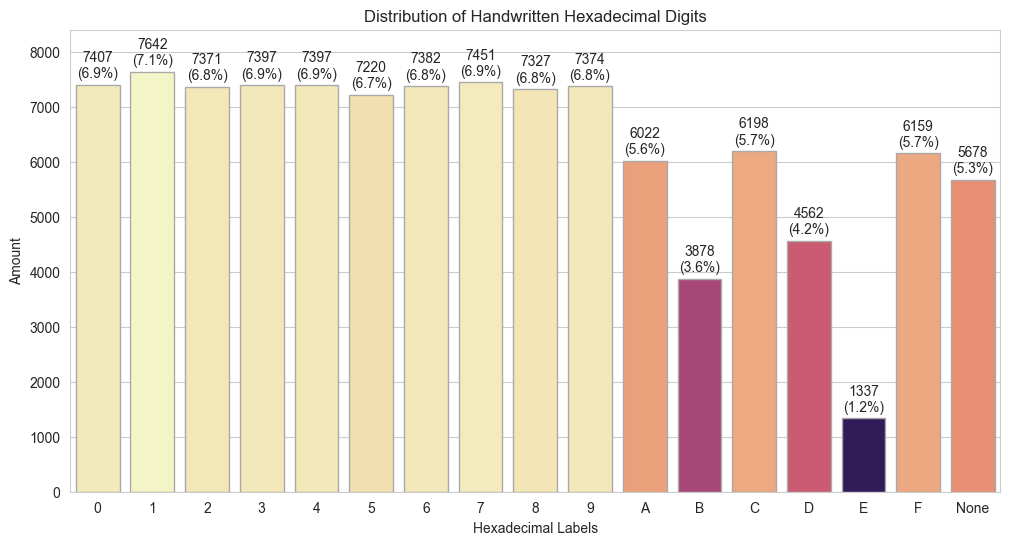

In [110]:
plt.figure(figsize=(12, 6))
colors = plt.cm.magma(counts / max(counts))

ax = sns.barplot(x=labels, y=counts, palette=colors, edgecolor="darkgray")

for i, count in enumerate(counts):
    percentage = f"({count / sum(counts) * 100:.1f}%)"
    ax.text(i, count + max(counts) * 0.01, f"{count}\n{percentage}", ha="center", va="bottom")

upper_limit = max(counts) + max(counts) * 0.1
plt.ylim(0, upper_limit)

plt.title("Distribution of Handwritten Hexadecimal Digits")
plt.xlabel("Hexadecimal Labels")
plt.ylabel("Amount")
plt.show()

## Data Preprocessing

### Data Splitting
Training and test sets created, maintaining the original class distribution.

In [111]:
# Stratify ensures that the train and test datasets have the same proportions of class labels as the original dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=seed)

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (75461, 400)
Test data shape: (32341, 400)


### Data Scaling
Feature normalization to achieve a uniform scale, enhancing the algorithm's efficiency and performance

In [112]:
# Scaling the features to a range of [0, 1]
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Denoising Autoencoder
Enhanced feature extraction for classification models with cleaned noisy data.

In [113]:
# Define the input layer with an input shape corresponding to the number of features (20*20)
input_img = Input(shape=(20 * 20,))

# Define the encoding layers:
encoded = Dense(128, activation="relu")(input_img)
encoded = Dense(64, activation="relu")(encoded)
decoded = Dense(128, activation="relu")(encoded)
decoded = Dense(20 * 20, activation="sigmoid")(decoded)

# Create the autoencoder model that maps the input to its reconstruction
autoencoder = Model(input_img, decoded)

# Compile the model using Adam optimizer and binary cross-entropy loss function
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

# Train the autoencoder to learn the optimal encoded representation for input reconstruction
# It uses the training data as both the input and target, effectively learning to reconstruct the input data
autoencoder.fit(X_train, X_train, epochs=50, batch_size=256)

Epoch 1/50
295/295 [==============================] - 1s 3ms/step - loss: 0.4842
Epoch 2/50
295/295 [==============================] - 1s 3ms/step - loss: 0.4343
Epoch 3/50
295/295 [==============================] - 1s 3ms/step - loss: 0.4248
Epoch 4/50
295/295 [==============================] - 1s 3ms/step - loss: 0.4205
Epoch 5/50
295/295 [==============================] - 1s 3ms/step - loss: 0.4180
Epoch 6/50
295/295 [==============================] - 1s 3ms/step - loss: 0.4163
Epoch 7/50
295/295 [==============================] - 1s 3ms/step - loss: 0.4153
Epoch 8/50
295/295 [==============================] - 1s 3ms/step - loss: 0.4145
Epoch 9/50
295/295 [==============================] - 1s 3ms/step - loss: 0.4138
Epoch 10/50
295/295 [==============================] - 1s 3ms/step - loss: 0.4132
Epoch 11/50
295/295 [==============================] - 1s 3ms/step - loss: 0.4127
Epoch 12/50
295/295 [==============================] - 1s 3ms/step - loss: 0.4123
Epoch 13/50
295/295 [====

In [114]:
X_train = autoencoder.predict(X_train)

2359/2359 [==============================] - 1s 495us/step


In [115]:
X_test = autoencoder.predict(X_test)

1011/1011 [==============================] - 1s 498us/step


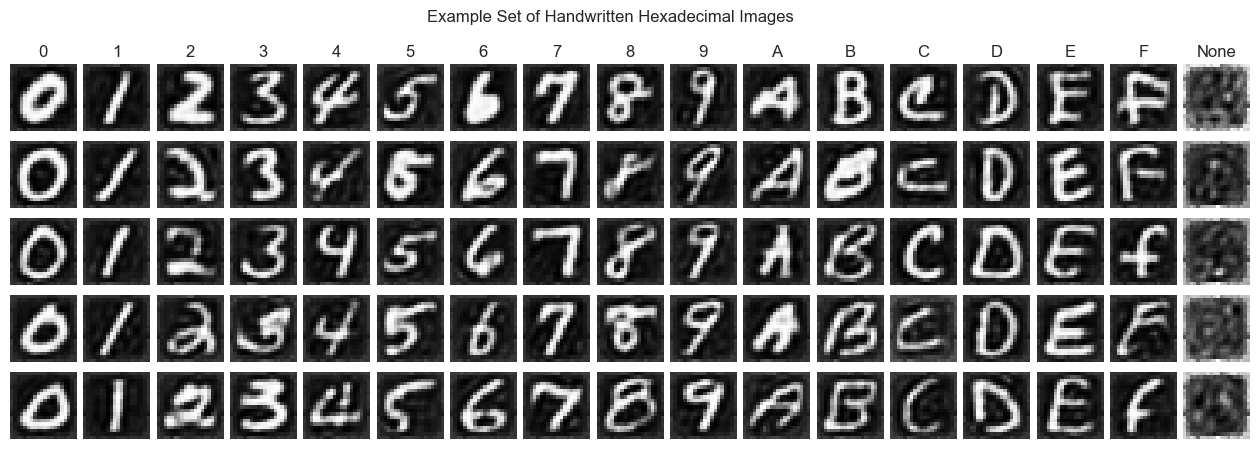

In [116]:
plot_examples(X_train, y_train)

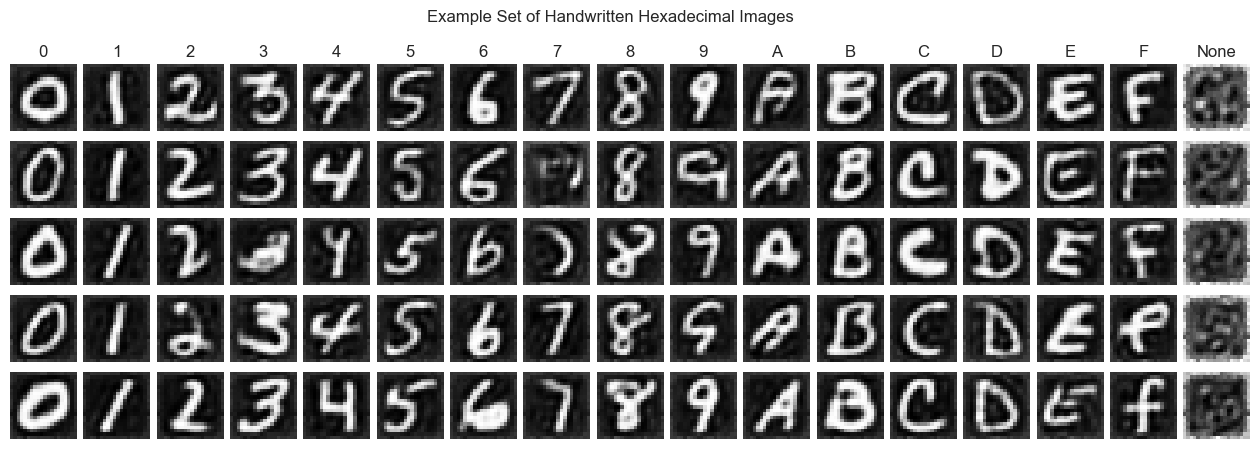

In [117]:
plot_examples(X_test, y_test)

## CNN Model Training
CNN model for image classification, with class weights balancing the learning process and early stopping preventing overfitting. 
The approach is a modification of [a Keras example](https://keras.io/examples/vision/mnist_convnet/).

In [118]:
# Reshaping the training data to fit the input requirements of a CNN. The first dimension is the number of samples, followed by 
# the image's height and width, and the last dimension represents the number of color channels (1 for grayscale images)
X_train_cnn = X_train.reshape((X_train.shape[0], 20, 20, 1))

# Defining the input shape for the CNN model, which matches the reshaped dimensions of the training data
input_shape = (20, 20, 1)

# Converting the training labels into one-hot encoding to match the output neurons of the CNN model
y_train_cnn = keras.utils.to_categorical(y_train, num_classes)

In [119]:
# Building the CNN model for image classification
cnn_model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

# Displaying the structure of the CNN model
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 18, 18, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 9, 9, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 3, 3, 64)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 576)               0         
                                                                 
 dropout_1 (Dropout)         (None, 576)              

In [120]:
# Compute class weights to handle class imbalance. The 'balanced' mode uses the values of y to automatically adjust weights 
# inversely proportional to class frequencies in the input data
class_weights = class_weight.compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)

# Convert class weights to a dictionary to be passed to the model during training
class_weight_dict = dict(enumerate(class_weights))

# Compile the CNN model with categorical crossentropy as the loss function, Adam as the optimizer, and accuracy as the evaluation metric
cnn_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Initialize early stopping to monitor validation loss. Training will stop if validation loss does not improve after 5 epochs, 
# and the best weights will be restored
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=1, restore_best_weights=True)

cnn_start_time = time.time()

# Train the CNN model with the training data, using class weights to handle class imbalance, batch size of 128, for 50 epochs, and with 
# a 10% validation split for on-the-fly validation. Early stopping is also enabled to prevent overfitting
history = cnn_model.fit(
    X_train_cnn, y_train_cnn,
    class_weight=class_weight_dict,
    batch_size=128,
    epochs=50,
    validation_split=0.1,
    callbacks=[early_stopping]
)

cnn_end_time = time.time()
cnn_elapsed_time = cnn_end_time - cnn_start_time

cnn_model.summary()
print(f"Total training time for CNN: {cnn_elapsed_time:.2f} seconds")

Epoch 1/50
531/531 [==============================] - 4s 7ms/step - loss: 0.8063 - accuracy: 0.7617 - val_loss: 0.2502 - val_accuracy: 0.9266
Epoch 2/50
531/531 [==============================] - 4s 7ms/step - loss: 0.3061 - accuracy: 0.9101 - val_loss: 0.1817 - val_accuracy: 0.9433
Epoch 3/50
531/531 [==============================] - 4s 7ms/step - loss: 0.2440 - accuracy: 0.9291 - val_loss: 0.1484 - val_accuracy: 0.9548
Epoch 4/50
531/531 [==============================] - 4s 7ms/step - loss: 0.2131 - accuracy: 0.9375 - val_loss: 0.1311 - val_accuracy: 0.9612
Epoch 5/50
531/531 [==============================] - 4s 7ms/step - loss: 0.1941 - accuracy: 0.9423 - val_loss: 0.1272 - val_accuracy: 0.9648
Epoch 6/50
531/531 [==============================] - 4s 7ms/step - loss: 0.1766 - accuracy: 0.9480 - val_loss: 0.1140 - val_accuracy: 0.9681
Epoch 7/50
531/531 [==============================] - 4s 7ms/step - loss: 0.1682 - accuracy: 0.9507 - val_loss: 0.1091 - val_accuracy: 0.9671
Epoch 

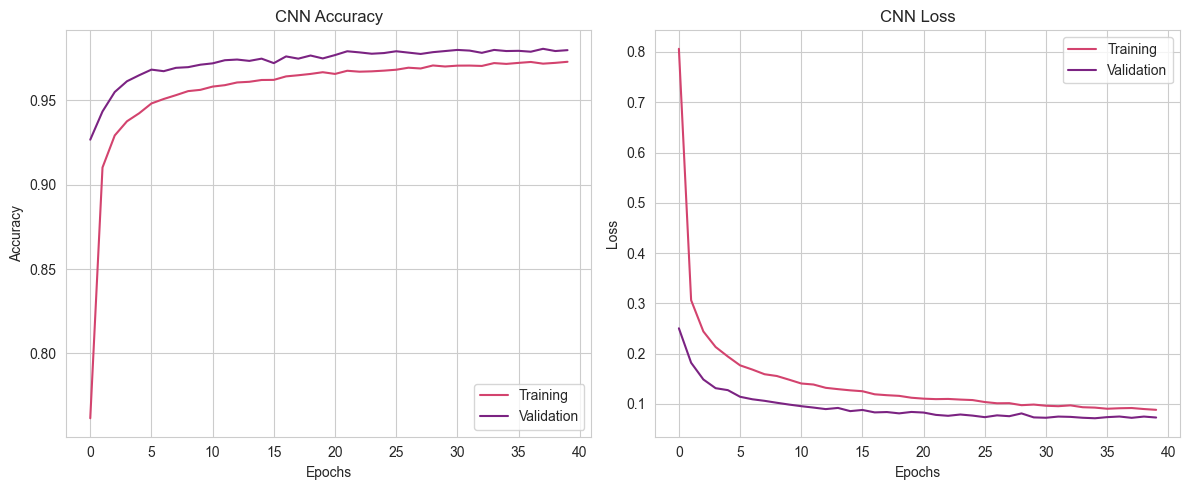

In [121]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)

plt.plot(history.history["accuracy"], label="Training", color=cmap[8])
plt.plot(history.history["val_accuracy"], label="Validation", color=cmap[5])
plt.title("CNN Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training", color=cmap[8])
plt.plot(history.history["val_loss"], label="Validation", color=cmap[5])
plt.title("CNN Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

In [220]:
# Create a layered visualization of the CNN model and display it
visualkeras.layered_view(cnn_model).show()
visualkeras.layered_view(cnn_model).save("cnn_model.png")

## Dimensionality Reduction
Dataset simplification through Principal Component Analysis (PCA) for concise feature representation while maintaining essential data characteristics and integrity. The optimal number of principal components ensures 90% data variance capture, striking a balance between computational efficiency and comprehensive data representation.


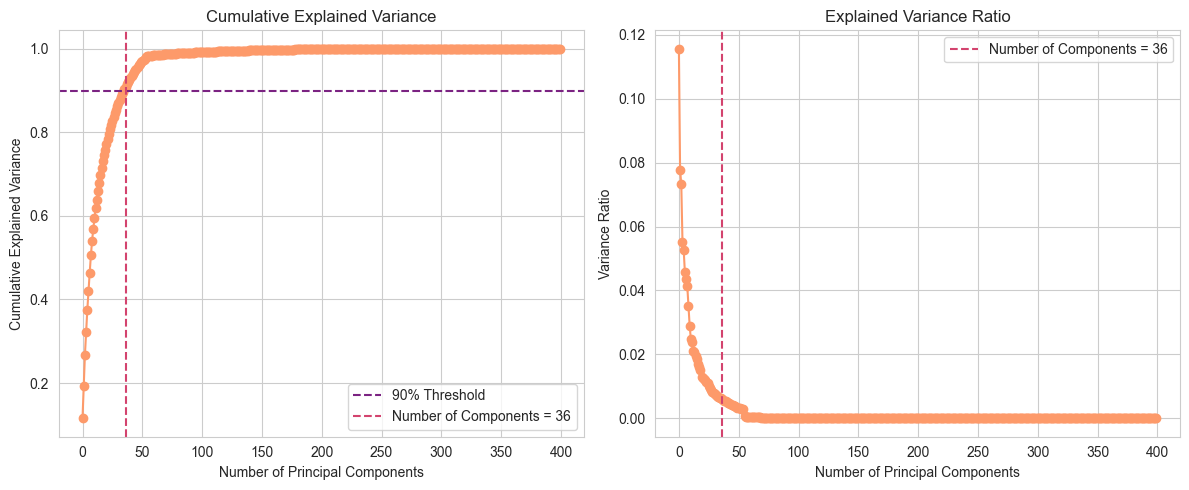

In [122]:
# Create a PCA object and fit it to the training data to analyze the principal components
pca = PCA(random_state=seed)
pca.fit(X_train)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of principal components that explain at least 90% of the variance
num_components_90 = np.where(cumulative_variance >= 0.90)[0][0] + 1

# Plot the cumulative explained variance and mark the 90% threshold
plt.plot(cumulative_variance, marker="o", color=cmap[11])
plt.axhline(y=0.90, color=cmap[5], linestyle="--", label="90% Threshold")
plt.axvline(x=num_components_90, color=cmap[8], linestyle="--", label=f"Number of Components = {num_components_90}")

plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance")
plt.legend()

plt.subplot(1, 2, 2)

# Plot the explained variance ratios of the principal components
plt.plot(pca.explained_variance_ratio_, marker="o", color=cmap[11])

# Mark the position of the principal component that reaches the 90% threshold
plt.axvline(x=num_components_90, color=cmap[8], linestyle="--", label=f"Number of Components = {num_components_90}")
plt.xlabel("Number of Principal Components")
plt.ylabel("Variance Ratio")
plt.title("Explained Variance Ratio")
plt.legend()

plt.tight_layout()
plt.show()

In [123]:
# Creating a PCA model with the number of components that capture 90% of the variance in the data
pca = PCA(n_components=num_components_90, random_state=seed)

# Applying PCA to both training and test datasets, ensuring PCA is fit only on the training data to prevent data leakage.
# The test data is then transformed using the same principal components to maintain consistency in the data structure
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [124]:
X_train_pca.shape, X_test_pca.shape

((75461, 36), (32341, 36))

## Grid Search for Hyperparameter Tuning
Identification of the most effective hyperparameters, optimizing the performance of ML models by exploring multiple combinations and evaluating each of them to determine the parameters that yield the highest accuracy and model efficiency.

In [125]:
def perform_grid_search(model, param_grid, X, y, cv, n_jobs=-1, verbose=1):
    """
    Perform grid search for a given model and parameter grid.
    
    Parameters:
    model (object): The machine learning model.
    param_grid (dict or list of dict): The parameter grid or list of parameter grids to search.
    X (np.array): Image array.
    y (np.array): Target labels.
    cv (int): Number of folds in cross-validation.
    n_jobs (int): Number of jobs to run in parallel.
    verbose (int): Verbosity level of the output.
    
    Returns:
    grid_search (GridSearchCV): Trained grid search object.
    """
    # Creating a pipeline with SMOTE for handling class imbalance and the model to be tuned
    pipeline = Pipeline([
        ("smote", SMOTE(random_state=seed)),
        ("model", model)
    ])

    # Adjust the parameter grid to work with the pipeline
    if isinstance(param_grid, dict):
        param_grid = {f"model__{key}": value for key, value in param_grid.items()}
    elif isinstance(param_grid, list):
        param_grid = [{f"model__{key}": value for key, value in grid.items()} for grid in param_grid]
    else:
        raise TypeError("param_grid should be a dict or a list of dicts.")

    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, scoring="accuracy",
                               return_train_score=True, n_jobs=n_jobs, verbose=verbose)
    grid_search.fit(X, y)

    return grid_search

In [162]:
knn_params = {
    "n_neighbors": list(range(1, 10, 2)),
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}

In [127]:
dt_params = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 4, 6],
    "min_samples_leaf": [1, 2, 4]
}

In [128]:
svm_params = [
    {"kernel": ["linear"], "C": [0.1, 1, 10]},
    {"kernel": ["rbf"], "C": [0.1, 1, 10]},
    {"kernel": ["poly"], "C": [0.1, 1, 10], "degree": [2, 3, 5]}
]

In [129]:
rf_params = {
    "criterion": ["gini", "entropy"],
    "n_estimators": [100, 200, 400]
}

In [34]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

In [163]:
knn_grid_search = perform_grid_search(KNeighborsClassifier(), knn_params, X_train_pca, y_train, cv)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [40]:
dt_grid_search = perform_grid_search(DecisionTreeClassifier(random_state=seed), dt_params, X_train_pca, y_train, cv)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [43]:
svm_grid_search = perform_grid_search(SVC(random_state=seed), svm_params, X_train_pca, y_train, cv)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


In [46]:
rf_grid_search = perform_grid_search(RandomForestClassifier(random_state=seed), rf_params, X_train_pca, y_train, cv)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


## Results Visualization
Comparison of performance across hyperparameter combinations.

In [187]:
def plot_cv_results(grid_search, sort_values=False, fig_size=(12, 8), title=""):
    """
    Plot the results of a cross-validated grid search showing both train and test scores.

    Parameters:
    grid_search: The fitted GridSearchCV object.
    sort_values: Whether the values should be sorted.
    title: The title of the plot.
    """
    cv_results = grid_search.cv_results_

    test_scores = cv_results["mean_test_score"] * 100
    train_scores = cv_results["mean_train_score"] * 100

    params = cv_results["params"]

    # Sorting the scores and parameter combinations by test scores if sort_values is True
    if sort_values:
        sorted_indices = np.argsort(test_scores)[::-1]
        test_scores = test_scores[sorted_indices]
        train_scores = train_scores[sorted_indices]
        params = [params[idx] for idx in sorted_indices]

    x_labels = [str(param) for param in params]

    plt.figure(figsize=fig_size)

    bar_width = 0.35
    index = np.arange(len(x_labels))

    plt.bar(index, test_scores, bar_width, label="Mean Test Score", color=cmap[5])
    plt.bar(index + bar_width, train_scores, bar_width, label="Mean Train Score", color=cmap[8])

    plt.xlabel("Parameter Combinations")
    plt.ylabel("Scores (%)")
    plt.title(title)
    plt.xticks(index + bar_width / 2, x_labels, rotation=90)
    plt.legend()

    plt.tight_layout()
    plt.show()

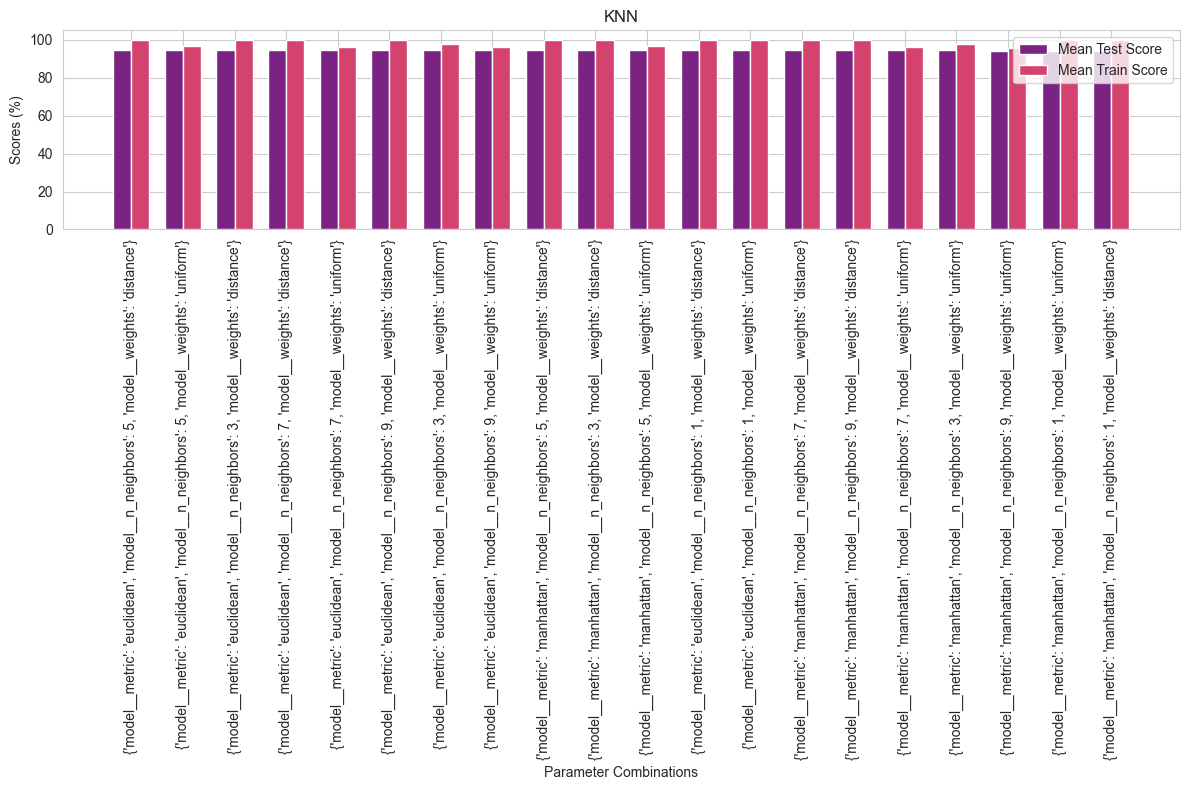

In [188]:
plot_cv_results(knn_grid_search, sort_values=True, fig_size=(12, 8), title="KNN")

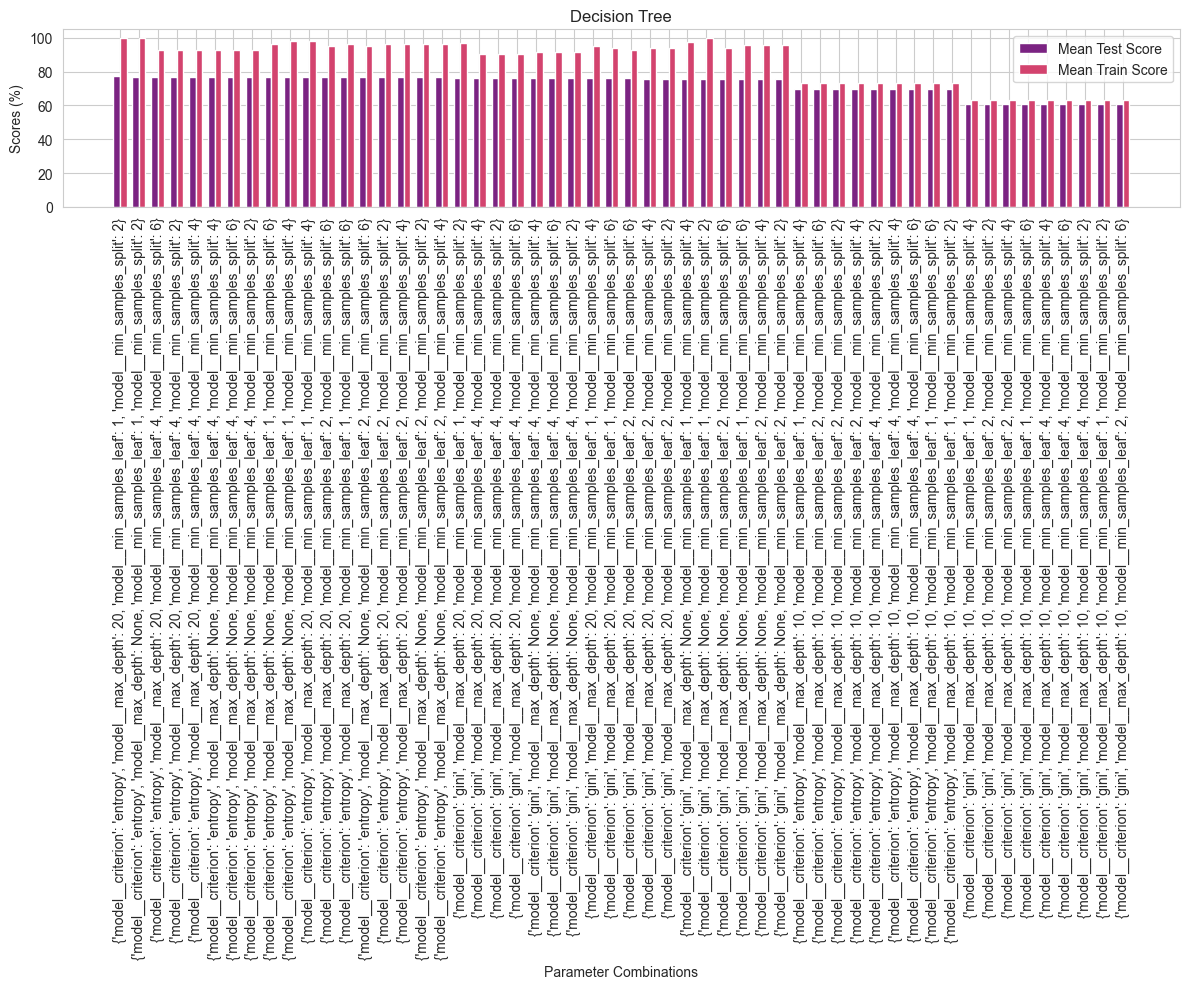

In [189]:
plot_cv_results(dt_grid_search, sort_values=True, fig_size=(12, 10), title="Decision Tree")

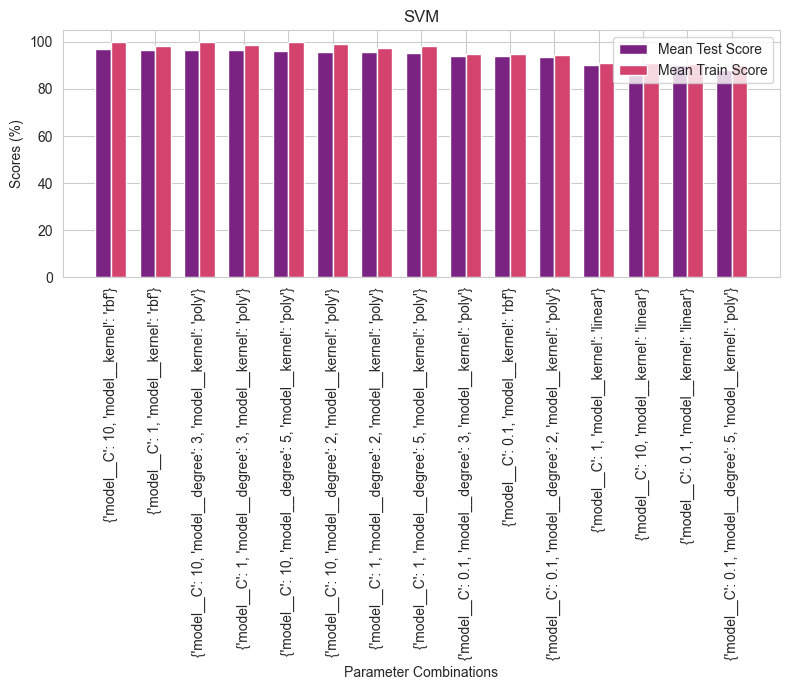

In [190]:
plot_cv_results(svm_grid_search, sort_values=True, fig_size=(8, 7), title="SVM")

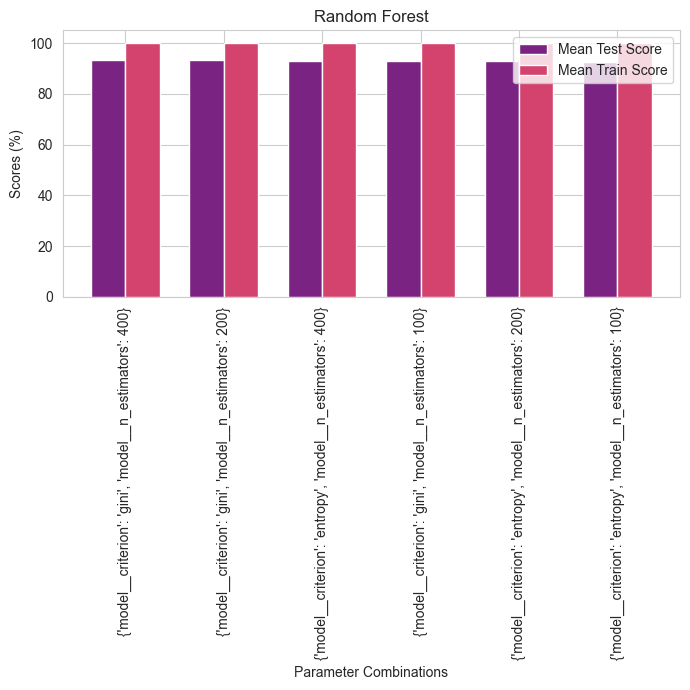

In [191]:
plot_cv_results(rf_grid_search, sort_values=True, fig_size=(7, 7), title="Random Forest")

In [182]:
def print_cv_results(grid_search, sort_by="mean_test_score"):
    """
    Print the mean fit time, mean score time, mean train score, and mean test score 
    of the grid search results, sorted by the specified key.

    Parameters:
    grid_search: The fitted GridSearchCV object.
    sort_by: The key by which to sort the results.
    """
    cv_results = grid_search.cv_results_

    # Combine all the results and parameters into a list of dictionaries
    all_results = [
        {
            "params": params,
            "mean_fit_time": fit_time,
            "mean_score_time": score_time,
            "mean_train_score": train_score,
            "mean_test_score": test_score
        }
        for params, fit_time, score_time, train_score, test_score
        in zip(
            cv_results["params"],
            cv_results["mean_fit_time"],
            cv_results["mean_score_time"],
            cv_results["mean_train_score"],
            cv_results["mean_test_score"]
        )
    ]

    # Sort the results by the specified key
    sorted_results = sorted(all_results, key=lambda x: x[sort_by], reverse=True)

    for result in sorted_results:
        print(f"Parameters:           {result['params']}")
        print(f"Training time:        {result['mean_fit_time']:.5f}s")
        print(f"Scoring time:         {result['mean_score_time']:.5f}s")
        print(f"Train score:          {result['mean_train_score'] * 100:.5f}%")
        print(f"Validation score:     {result['mean_test_score'] * 100:.5f}%")
        print()

In [183]:
print_cv_results(knn_grid_search)

Parameters:           {'model__metric': 'euclidean', 'model__n_neighbors': 5, 'model__weights': 'distance'}
Training time:        1.13026s
Scoring time:         5.07643s
Train score:          100.00000%
Validation score:     94.87550%

Parameters:           {'model__metric': 'euclidean', 'model__n_neighbors': 5, 'model__weights': 'uniform'}
Training time:        0.99651s
Scoring time:         4.99631s
Train score:          96.83777%
Validation score:     94.81056%

Parameters:           {'model__metric': 'euclidean', 'model__n_neighbors': 3, 'model__weights': 'distance'}
Training time:        0.99347s
Scoring time:         4.70251s
Train score:          100.00000%
Validation score:     94.77743%

Parameters:           {'model__metric': 'euclidean', 'model__n_neighbors': 7, 'model__weights': 'distance'}
Training time:        0.94385s
Scoring time:         4.50613s
Train score:          100.00000%
Validation score:     94.76948%

Parameters:           {'model__metric': 'euclidean', 'mode

In [184]:
print_cv_results(dt_grid_search)

Parameters:           {'model__criterion': 'entropy', 'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
Training time:        9.48746s
Scoring time:         0.00475s
Train score:          99.96886%
Validation score:     77.15111%

Parameters:           {'model__criterion': 'entropy', 'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
Training time:        9.35481s
Scoring time:         0.00444s
Train score:          100.00000%
Validation score:     77.06365%

Parameters:           {'model__criterion': 'entropy', 'model__max_depth': 20, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2}
Training time:        9.19212s
Scoring time:         0.00390s
Train score:          92.66442%
Validation score:     77.04377%

Parameters:           {'model__criterion': 'entropy', 'model__max_depth': 20, 'model__min_samples_leaf': 4, 'model__min_samples_split': 4}
Training time:        9.12104s
Scoring time:         0.00424

In [185]:
print_cv_results(svm_grid_search)

Parameters:           {'model__C': 10, 'model__kernel': 'rbf'}
Training time:        28.40626s
Scoring time:         21.61641s
Train score:          99.85920%
Validation score:     97.03555%

Parameters:           {'model__C': 1, 'model__kernel': 'rbf'}
Training time:        35.99550s
Scoring time:         25.17801s
Train score:          98.16329%
Validation score:     96.54391%

Parameters:           {'model__C': 10, 'model__degree': 3, 'model__kernel': 'poly'}
Training time:        46.90152s
Scoring time:         9.37524s
Train score:          99.87808%
Validation score:     96.48958%

Parameters:           {'model__C': 1, 'model__degree': 3, 'model__kernel': 'poly'}
Training time:        64.50517s
Scoring time:         10.87072s
Train score:          98.56217%
Validation score:     96.44849%

Parameters:           {'model__C': 10, 'model__degree': 5, 'model__kernel': 'poly'}
Training time:        73.24718s
Scoring time:         8.81853s
Train score:          99.89034%
Validation sco

In [186]:
print_cv_results(rf_grid_search)

Parameters:           {'model__criterion': 'gini', 'model__n_estimators': 400}
Training time:        273.91593s
Scoring time:         1.94285s
Train score:          100.00000%
Validation score:     93.39659%

Parameters:           {'model__criterion': 'gini', 'model__n_estimators': 200}
Training time:        135.70954s
Scoring time:         0.88298s
Train score:          100.00000%
Validation score:     93.31177%

Parameters:           {'model__criterion': 'entropy', 'model__n_estimators': 400}
Training time:        396.30829s
Scoring time:         1.39579s
Train score:          100.00000%
Validation score:     93.11962%

Parameters:           {'model__criterion': 'gini', 'model__n_estimators': 100}
Training time:        69.00577s
Scoring time:         0.41722s
Train score:          100.00000%
Validation score:     93.00698%

Parameters:           {'model__criterion': 'entropy', 'model__n_estimators': 200}
Training time:        234.50486s
Scoring time:         0.72627s
Train score:    

## Model Evaluation
Selection and performance estimation of the best model based on validation accuracies.

In [140]:
# Creating a dictionary to store the best validation accuracies of each trained model
model_accuracies = {
    "CNN": max(history.history["val_accuracy"]),
    "KNN": knn_grid_search.best_score_,
    "Decision Tree": dt_grid_search.best_score_,
    "SVM": svm_grid_search.best_score_,
    "Random Forest": rf_grid_search.best_score_
}

In [141]:
print(f"Model Accuracies on Validation Data:")

for model_name, accuracy in model_accuracies.items():
    print(f"{model_name:<25}{round(accuracy * 100, 5):>10}%")

Model Accuracies on Validation Data:
CNN                        98.03895%
KNN                         94.8755%
Decision Tree              77.15111%
SVM                        97.03555%
Random Forest              93.39659%


In [142]:
best_model_name = max(model_accuracies, key=model_accuracies.get)

print(f"Best Model Based on Validation Data: {best_model_name}")

Best Model Based on Validation Data: CNN


In [143]:
grid_searches = {
    "KNN": knn_grid_search,
    "Decision Tree": dt_grid_search,
    "SVM": svm_grid_search,
    "Random Forest": rf_grid_search
}

In [228]:
# printing the best model found by each grid search
for g_s in grid_searches.values():
    print(g_s.best_estimator_["model"])

KNeighborsClassifier(metric='euclidean', weights='distance')
DecisionTreeClassifier(criterion='entropy', max_depth=20, random_state=123)
SVC(C=10, random_state=123)
RandomForestClassifier(n_estimators=400, random_state=123)


In [144]:
if best_model_name == "CNN":
    # Reshape the test data to match the input shape expected by the CNN model
    X_test_cnn = X_test.reshape((X_test.shape[0], 20, 20, 1))

    # Convert the test labels into one-hot encoded format as expected by the CNN model
    y_test_cnn = keras.utils.to_categorical(y_test, num_classes)

    start_time = time.time()

    # The model predicts the probabilities of each class for the test data
    y_pred_probs = cnn_model.predict(X_test_cnn)
    end_time = time.time()

    # Convert the predicted probabilities to class labels by selecting the class with the highest probability
    y_test_pred = y_pred_probs.argmax(axis=1)

    test_loss, test_accuracy = cnn_model.evaluate(X_test_cnn, y_test_cnn)
else:
    # If the best model is not the CNN, we select the best model from the grid search results
    best_model = grid_searches[best_model_name].best_estimator_

    start_time = time.time()

    # The model makes predictions on the test data transformed by PCA
    y_test_pred = best_model.predict(X_test_pca)
    end_time = time.time()

    test_accuracy = accuracy_score(y_test, y_test_pred)

prediction_time = end_time - start_time
print(f"Prediction time for {best_model_name}: {prediction_time:.4f} seconds")
print(f"Test Accuracy of {best_model_name}: {test_accuracy}")

1011/1011 [==============================] - 1s 994us/step - loss: 0.0729 - accuracy: 0.9772
Prediction time for CNN: 1.1208 seconds
Test Accuracy of CNN: 0.9772425293922424


## Classification Report
Generating a detailed classification report to evaluate the precision, recall, and F1-score of the model for each class.

In [145]:
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2222
           1       0.99      1.00      0.99      2293
           2       0.99      0.98      0.98      2211
           3       0.98      0.98      0.98      2219
           4       0.98      0.98      0.98      2219
           5       0.98      0.98      0.98      2166
           6       0.99      0.99      0.99      2215
           7       0.98      0.99      0.98      2235
           8       0.98      0.95      0.97      2198
           9       0.98      0.98      0.98      2212
          10       0.97      0.99      0.98      1807
          11       0.95      0.94      0.95      1163
          12       0.97      0.99      0.98      1860
          13       0.93      0.94      0.93      1369
          14       0.96      0.96      0.96       401
          15       0.97      0.97      0.97      1848
          16       1.00      1.00      1.00      1703

   

## Confusion Matrix
Plotting the confusion matrix to visualize the model’s performance, showcasing where the model is making mistakes in classification.

In [221]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    """
    Plot the confusion matrix for the model's predictions.

    Parameters:
    y_true (np.array): True labels.
    y_pred (np.array): Predicted labels.
    model_name (str): Name of the model.
    """
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="flare", xticks_rotation="vertical")

    disp.ax_.set_xticks(np.arange(len(labels)))
    disp.ax_.set_yticks(np.arange(len(labels)))
    disp.ax_.set_xticklabels(labels)
    disp.ax_.set_yticklabels(labels)

    plt.title(f"{model_name}\nConfusion Matrix")
    plt.show()

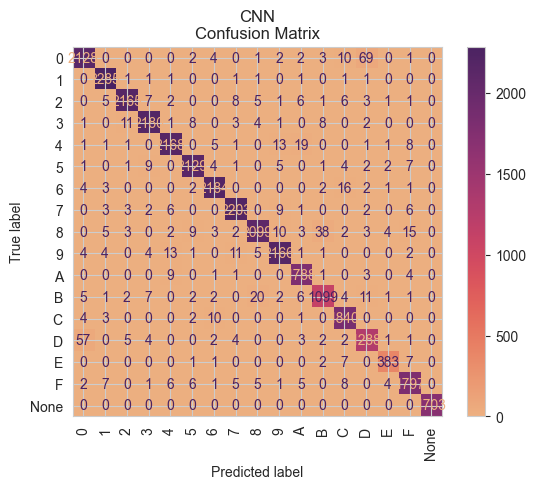

In [222]:
plot_confusion_matrix(y_test, y_test_pred, best_model_name)

## Label Comparison
Illustration of model prediction accuracy and areas of misclassification.

In [148]:
def plot_label_comparison(X, y_true, y_pred, model_name):
    """
    Plot a comparison of true and predicted labels for the data.

    Parameters:
    X (np.array): Image array.
    y_true (np.array): True labels.
    y_pred (np.array): Predicted labels.
    model_name (str): Name of the model.
    """
    misclassified_indices = np.where(y_true != y_pred)[0]
    plot_indices = misclassified_indices[:25]

    fig = plt.figure(figsize=(5, 5))

    for i, idx in enumerate(plot_indices):
        ax = fig.add_subplot(5, 5, i + 1)
        ax.imshow(X[idx].reshape(20, 20), cmap="gray")
        ax.set_title(f"{class_to_label[y_true[idx]]} / {class_to_label[y_pred[idx]]}")
        ax.axis("off")

    fig.suptitle(f"{model_name}\nTrue Label / Predicted Label")
    fig.tight_layout(pad=0.5)
    plt.show()

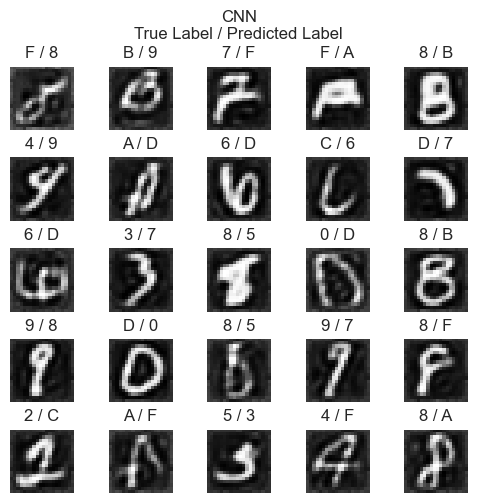

In [149]:
plot_label_comparison(X_test, y_test, y_test_pred, best_model_name)